## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""

def combined_loss(ce_weight=0., gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    ce_weight = float(ce_weight)
    
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        
        f1 = tf.multiply(alpha, tf.multiply(weight, ce))
        f1_weight = 1.0 - ce_weight
        
        combined_ce_f1 = tf.add(tf.multiply(f1_weight, f1), tf.multiply(ce_weight, ce))
        reduced_f1 = tf.reduce_max(combined_ce_f1, axis=1)
        return tf.reduce_mean(reduced_f1)
    
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [16]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_weight = ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128) 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 115us/step - loss: 4.9329 - acc: 0.3210 - val_loss: 4.7486 - val_acc: 0.3352
Epoch 2/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.6030 - acc: 0.4402 - val_loss: 3.8266 - val_acc: 0.4183
Epoch 3/25
50000/50000 [==============================] - 5s 98us/step - loss: 3.2776 - acc: 0.4800 - val_loss: 3.6070 - val_acc: 0.4356
Epoch 4/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.0645 - acc: 0.5054 - val_loss: 3.5110 - val_acc: 0.4427
Epoch 5/25
50000/50000 [==============================] - 4s 88us/step - loss: 2.8975 - acc: 0.5265 - val_loss: 3.3313 - val_acc: 0.4672
Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.7519 - acc: 0.5457 - val_loss: 3.2779 - val_acc: 0.4659
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 2.6258 - acc: 0.5624 - val_loss: 3.3259 - val_ac

50000/50000 [==============================] - 5s 93us/step - loss: 1.1250 - acc: 0.7664 - val_loss: 2.9205 - val_acc: 0.4834
Epoch 25/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0736 - acc: 0.7781 - val_loss: 2.9002 - val_acc: 0.4846
Numbers of exp: 3, ce_weight: 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256) 

Epoch 12/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2458 - acc: 0.5717 - val_loss: 1.4824 - val_acc: 0.4820
Epoch 13/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.2211 - acc: 0.5809 - val_loss: 1.4835 - val_acc: 0.4826
Epoch 14/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.1958 - acc: 0.5909 - val_loss: 1.4666 - val_acc: 0.4895
Epoch 15/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.1724 - acc: 0.5987 - val_loss: 1.4721 - val_acc: 0.4827
Epoch 16/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.1495 - acc: 0.6067 - val_loss: 1.4630 - val_acc: 0.4890
Epoch 17/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.1245 - acc: 0.6162 - val_loss: 1.4551 - val_acc: 0.4941
Epoch 18/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.1035 - acc: 0.6239 - val_loss: 1.4593 - val_acc: 0.4898
Epoch 19/25
50000/50000 [=========

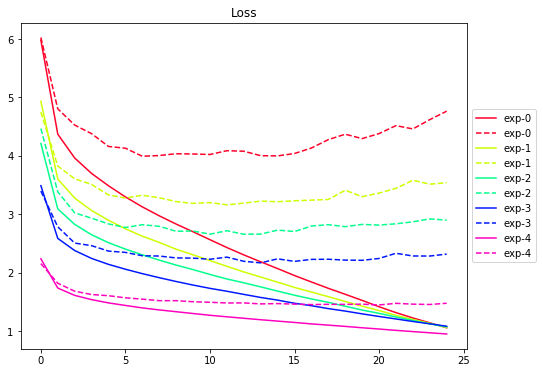

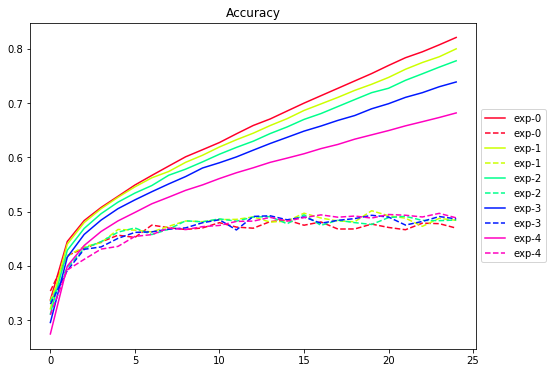

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()